In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# make the plot beautiful
sns.set_style('whitegrid')

In [4]:
def plot_results(results):
    """
    Plot the train/test RMSE results
    """
    # plot configuration
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)

    # exponential moving average of RMSE to smooth out the output
    _ = results.ewm(halflife=25).mean().plot(ax=ax)
    _ = ax.set_xlabel("Number of Epochs")
    _ = ax.set_ylabel("RMSE")
    _ = ax.set_title("Content-based Model Learning Curve")

    return fig, ax

## Getting the pre-train model & see results

In [3]:
# read in pre-train model
sgd = joblib.load('./data/model_sgd_regressor.joblib')
results = pd.read_feather('./data/model_sgd_regressor_scores.feather')

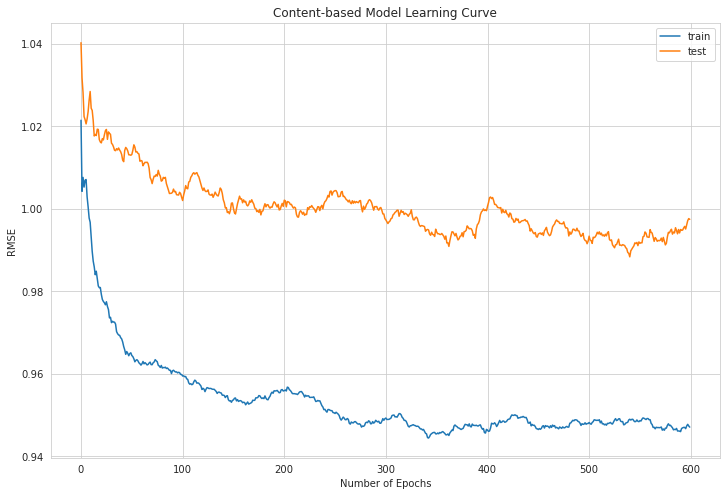

In [4]:
# plot the pre-train results
fig, ax = plot_results(results)

## Getting new Train/Test datasets

In [5]:
def get_train_test(batch_size=5000):
    """Constructing the finalized dataset for model"""
    # samples from rating histories
    sample = hist.sample(batch_size)
    sample = sample.join(user_profile).join(feature_movies)

    # concate user profile and movie genome features to one
    # normalize each row, so that euclidean distance perserve cosine distance
    sample['train'] = (
        sample[~sample.train.isna()]
        .apply(lambda x: np.r_[x.train, x.genome], axis=1)
        .apply(lambda x: x / np.linalg.norm(x))
    )
    sample['test'] = (
        sample.apply(lambda x: np.r_[x.test, x.genome], axis=1)
        .apply(lambda x: x / np.linalg.norm(x))
    )

    # cleanup
    sample.drop(['genome'], axis=1, inplace=True)

    # get train & test subsets
    X_train = np.r_[sample[sample.is_train].train.to_list()]
    y_train = sample[sample.is_train].rating.to_numpy()

    X_test = np.r_[sample[~sample.is_train].test.to_list()]
    y_test = sample[~sample.is_train].rating.to_numpy()

    return X_train, y_train, X_test, y_test

In [5]:
# read in data for constructing training testing set
feature_movies = pd.read_feather('./data/feature_movies.feather').set_index('movieId')
user_profile = pd.read_feather('./data/feature_profile.feather').set_index('userId')
hist = pd.read_feather('./data/feature_hist.feather').set_index(['userId','movieId'])

In [7]:
# read in pre-train model
sgd = joblib.load('./data/model_sgd_regressor.joblib')

In [9]:
from sklearn.metrics import mean_squared_error

# get a batch of train/test dataset
X_train, y_train, X_test, y_test = get_train_test()

# calculate RMSE for this batch
train_score = np.sqrt(mean_squared_error(y_train, sgd.predict(X_train)))
test_score = np.sqrt(mean_squared_error(y_test, sgd.predict(X_test)))

print(f"Train RMSE = {train_score:0.3f}")
print(f"Test RMSE = {test_score:0.3f}")

Train RMSE = 0.956
Test RMSE = 0.988


## Rebuild the model from scratch

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

# initilize the SGD Linear Model with L2 loss and penlity
sgd = SGDRegressor(loss='squared_error', penalty='l2', alpha=0.001)
scores = []

# training loop
n_epochs = 600
batch_size = 5000
for epoch in tqdm(range(n_epochs)):
    # get train test data
    X_train, y_train, X_test, y_test = get_train_test(batch_size)

    # sgd batch fit
    sgd.partial_fit(X_train, y_train)

    # calcualte scores
    train_rmse = np.sqrt(mean_squared_error(y_train, sgd.predict(X_train)))
    test_rmse = np.sqrt(mean_squared_error(y_test, sgd.predict(X_test)))
    scores.append((epoch, train_rmse, test_rmse))

# read the train/test RMSE results into pandas dataframe
results = pd.DataFrame(scores, columns=['epoch','train', 'test'])[['train','test']]

In [ ]:
# plot out the new training results
fig, ax = plot_results(results)